# Task 2.1 Streaming Data Visualization

<IPython.core.display.Javascript object>


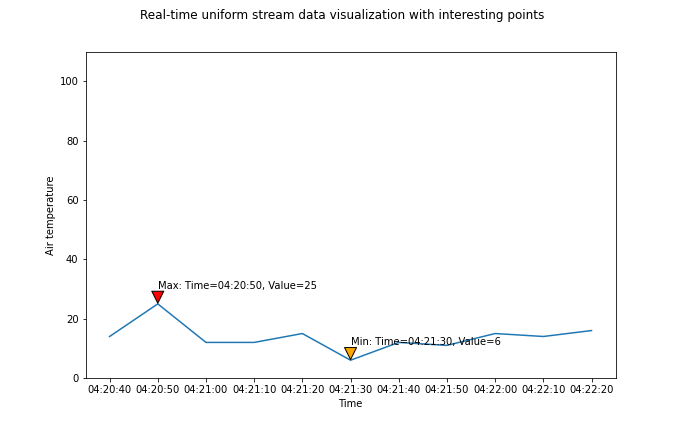

KeyboardInterrupt: 

In [280]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'partB'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('time')
        ax.set_ylabel('Air temperature')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
        
            # change message into json objeact (dictionary)
            data = message.value
            data = json.loads(data.decode('utf-8'))
            
            # only listen to climate (producer 1) data 
            if data['producer'] == 1:
                x.append(data["time"])
                y.append(int(data["air_temperature_celcius"]))
            
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air temperature')
                ax.set_ylim(0,110) 
                ax.set_yticks([0,20,40,60,80,100])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

# Task 2.2a Static Data Visualization

<IPython.core.display.Javascript object>


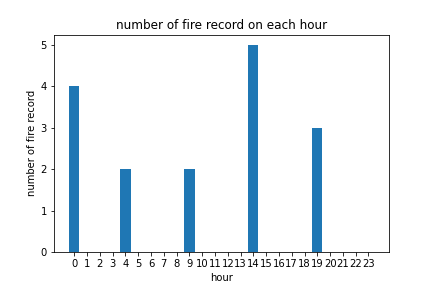

In [277]:
# import statement
from pprint import pprint
from pymongo import MongoClient

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

# connect to mongodb, get the database, and get the data
client = MongoClient()
db = client.fit3182_assignment_db
PartB = db.partB

# unwind the data 
fireList = db.partB.aggregate([{"$unwind" : "$hotspot"}])

# hour from 0-23
hourList = []
# count of fire in each hour 
fireInHour = []

# initialise the list
for i in range(24) : 
    hourList.append(str(i))
    fireInHour.append(0)
    
# get the hour of each fire and modify the fireInHour list
for data in fireList: 
    hour = int(data['hotspot']['time'][:2])
    fireInHour[hour] = int(fireInHour[hour]) + 1

# creating the bar plot and set the labels and title   
plt.bar(hourList, fireInHour)
plt.xlabel("hour")
plt.ylabel("number of fire record")
plt.title("number of fire record on each hour")

plt.show()

# Task 2.2.b Static Data Visualization

In [278]:
import folium

# initialise the map at victoria
fomap = folium.Map(location=[-37.020100, 144.964600], zoom_start=7)

# get the data from database 
fireList = db.partB.aggregate([{"$unwind" : "$hotspot"}])

# for every fire event
for data in fireList:
    
    # get the location 
    loc = (data['hotspot']['latitude'],data['hotspot']['longitude'])
    
    # determine the market color based on the cause of fire, blue for natural and red for other
    markerColor = "blue"
    if data['fire_cause'] == "other" : 
        markerColor = "red"
    
    # get informations to be displayed
    airTemp = round(data['air_temperature_celcius'])
    surfTemp = round(data['hotspot']['surface_temperature_celcius'])
    confidence = round(data['hotspot']['confidence'])
    humidity = round(data['relative_humidity']) 
    
    # set the popup message
    message = "Air Temp :" + str(airTemp) + "<br>" + "Surface Temp :" + str(surfTemp) + "<br>"
    message = message + "confidecne :" + str(confidence) + "<br>" + "humidity :" + str(humidity) + "<br>"
    
    # set up the marker
    folium.Marker(location=loc, tooltip = message , icon = folium.Icon(color = markerColor)).add_to(fomap)


In [279]:
# show the map
fomap